In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')

In [75]:
import h5py
import numpy as np
from astropy.units import deg
from os import path
#from lenstools import GaussianNoiseGenerator, ConvergenceMap
#from scipy.ndimage import gaussian_filter

I want to study the global property of the clone dsets that I made. Specifically, 
* Power spectra
* Peak counts
* General pixel counts

I also want to see if these have any trends with cosmology, esp compared to the original maps. 

Same as the other notebook, but loads up ones that were computed as a batch job. 

In [76]:
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTraining.hdf5'
grf_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingGRF_smooth_1.0_noise_0.3.hdf5'
clone_fname = '/scratch/users/swmclau2/clone_maps/UatuFastPMTrainingRobustifyDeepResnetRegAdvWhiteNoise0.0_v3.hdf5'
#clone_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingRobustifyDeepResnetRegAdvGRFNoise1.0.hdf5'

In [77]:
N = 200
all_ys = np.zeros((N, 2))
for boxno in range(N):
    #print(boxno)
    boxname = 'Box%03d'%boxno
    with h5py.File(orig_fname, 'r') as f:
        y = f[boxname]['Y'][0,:]
        
    all_ys[boxno] = y.squeeze()

In [78]:
directory = '/home/users/swmclau2/scratch/clone_maps/'
#pc_arrs = np.load(path.join(directory, 'pc_arrs_white_%d_ms.npy'%smooth), allow_pickle=True)
#pdf_arrs = np.load(path.join(directory, 'pdf_arrs_white_%d_ms.npy'%smooth), allow_pickle=True)

In [79]:
#sorted_y_idxs = np.argsort(all_ys[:,0])
#sorted_y_idxs = np.argsort(all_ys[:,1])

In [80]:
center_val = all_ys.mean(axis=0)
closest_to_center_idx = np.argmin(np.sum(np.abs(all_ys-center_val)**2, axis=1), axis=0)

In [81]:
closest_to_center_idx

82

In [82]:
norm_all_ys = (all_ys-np.min(all_ys, axis=0))/(np.max(all_ys,axis=0)-np.min(all_ys,axis=0))

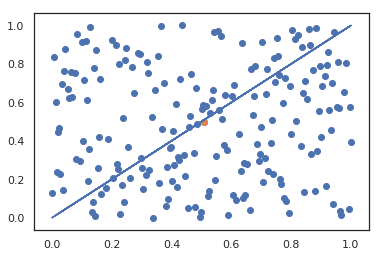

In [83]:
r = 0.5#0.5
slope_vec = np.array([r, 1-r])
slope = slope_vec[1]/slope_vec[0]
plt.scatter(norm_all_ys[:,0], norm_all_ys[:,1])
plt.scatter(norm_all_ys[closest_to_center_idx,0], norm_all_ys[closest_to_center_idx,1])
plt.plot(norm_all_ys[:,0], slope*norm_all_ys[:,0])

In [84]:
projection = np.dot( norm_all_ys, slope_vec)
sorted_y_idxs = np.argsort(projection)

In [85]:
cmap = sns.cubehelix_palette(N, start=2, rot=0, dark=0.1, light=.95)

In [86]:
_nu = np.linspace(-5, 10, 200)
nu = (_nu[1:]+_nu[:-1])/2.0

_l = np.linspace(128, 128**2, 180)
l = (_l[1:]+_l[:-1])/2.0

In [91]:
def plot_delta(fname, stat_name, x, xlabel, xlim, ylim, xscale, yscale,\
               errorbar=True, cosmo_no = closest_to_center_idx,
              norm = False):
    fig, axes = plt.subplots(2,2, figsize = (10,6), sharex=True,sharey=False)
    names = ['Noiseless', 'Noisy']
    print cosmo_no
    for smooth, (ax,name) in enumerate(zip(axes[0], names)):
        ps_arrs = np.load(path.join(directory, fname%smooth),\
                          allow_pickle=True)[:,:,cosmo_no]
        if norm:
            n = ps_arrs[0].sum(axis=1)
            ps_arrs[0]=(ps_arrs[0].T/n).T
            ps_arrs[1]=(ps_arrs[1].T/n).T
        
        if errorbar:
            ax.errorbar(x, ps_arrs[0][0], yerr=ps_arrs[1][0], color = 'b', label = 'Sim')

            ax.errorbar(x, ps_arrs[0][3], yerr = ps_arrs[1][3], color = 'r', label = 'Clone')
            
            ax.errorbar(x, ps_arrs[0][1],\
                        yerr = ps_arrs[1][1], color = 'g', label = 'GRF')
            #ax.errorbar(x, ps_arrs[0][2],\
            #            yerr = ps_arrs[1][2], color = 'm')

        else:
            ax.plot(x, ps_arrs[0][0], color = 'b', label = 'Sim')

            ax.plot(x, ps_arrs[0][3], color = 'r', label = 'Clone')
            
            ax.plot(x, ps_arrs[0][1], color = 'g', label = 'GRF')
            #ax.plot(x, ps_arrs[0][2], color = 'm')
        
        ax.loglog()
        ax.set_title(name)
        
    for a in axes[0]:
        #for a in ax:
        #a.set_ylim(ylim[0])
        a.set_xlim(xlim)

    for smooth, (ax,name) in enumerate(zip(axes[1], names)):
        ps_arrs = np.load(path.join(directory, fname%smooth), \
                          allow_pickle=True)[:,:,cosmo_no]
        if norm:
            n = ps_arrs[0].sum(axis=1)
            ps_arrs[0]=(ps_arrs[0].T/n).T
            ps_arrs[1]=(ps_arrs[1].T/n).T
            
        delta_err = lambda x: (-np.log10(ps_arrs[0][0])+\
                               np.log10(ps_arrs[0][x]),
                               1)#np.log10(ps_arrs[1][0]))#+\
                                 #ps_arrs[1][x]**2))

        delta, err = delta_err(3)
        ax.plot(x, delta/err, color = 'r')
        #ax.errorbar(x, delta/err, yerr = ps_arrs[1][3], color = 'r')
        delta, err = delta_err(1)
        ax.plot(x, delta/err, color = 'g')
        #ax.errorbar(x, delta/err, yerr = ps_arrs[1][1], color = 'g')

                
        #delta, err = delta_err(2)
        #ax.plot(x, delta/err, color = 'm')
        
        ax.plot(x, np.zeros_like(x), ls ='--', color = 'k', alpha = 0.4)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)

        ax.set_xlabel(xlabel)

    for a in axes[1]:
        #for a in ax:
        #a.set_ylim(ylim[1])
        a.set_xlim(xlim)
    axes[0][0].legend(loc='best')
    axes[1][0].set_ylabel('Log Difference')
    axes[0][0].set_ylabel(stat_name)
    plt.tight_layout()
    return fig

82


/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in add


Figure(720x432)


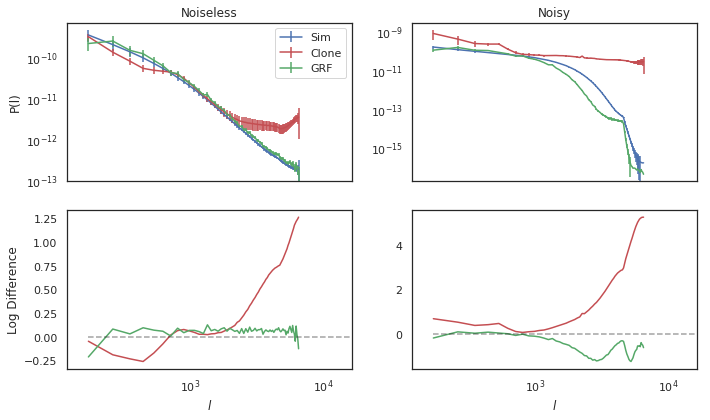

In [95]:
fig = plot_delta('ps_arrs_white_%d_ms.npy','P(l)', l, r'$l$', [120, 128**2+1],\
           [[5e-14, 5e-9], [-25,25]], 'log', 'linear')
print fig
#fig.savefig('ps_delta.pdf', format='pdf', bbox_inches='tight')

82


/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in add


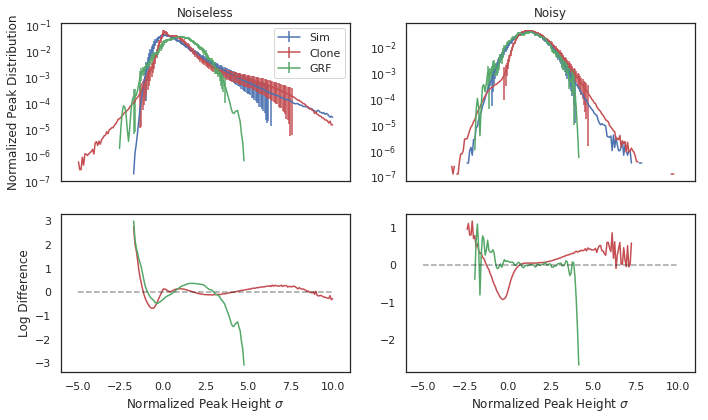

In [97]:
fig = plot_delta('pc_arrs_white_%d_ms.npy','Normalized Peak Distribution', nu, r'Normalized Peak Height $\sigma$', \
           [-6, 11],\
           [[1e-6,1e0], [-5,5]],
           #[[1e-2,1e4], [-10,5]],
           'linear', 'linear', True, norm=True)
fig.savefig('pc_delta.pdf', format='pdf', bbox_inches='tight')

82


/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in add


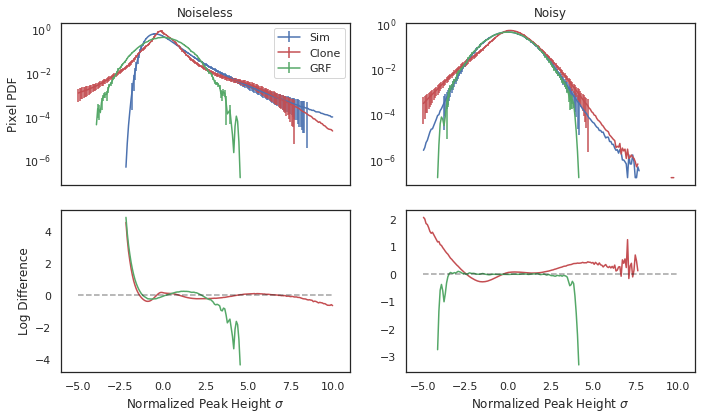

In [94]:
fig = plot_delta('pdf_arrs_white_%d_ms.npy', 'Pixel PDF', nu, r'Normalized Peak Height $\sigma$', \
           [-6, 11],\
           [[1e-6, 1], [-5,5]], 'linear', 'linear', True)
fig.savefig('pdf_delta.pdf', format='pdf', bbox_inches='tight')